### Plotting an Optimal Route with Ant Colony Optimization

So far so good, the graph seems to represent our mapped nodes well enough.

We will add our Ant Colony Optimization model to find the best route and reduce the decimal places of the weights for better visibility

In [102]:
import pandas as pd
df = pd.read_csv('transport_data_output.csv')

In [103]:
df.head(10)

,City of Origin,Destination City,Stopover City,Vehicle Plate,Distance (km),Vehicle Type,Speed (km/h),Fuel Consumption (L/100km),Traffic Congestion,Adjusted Speed (km/h),...,Peak Time,Off-Peak Time,Free-Flow Speed (km/h),Free-Flow Time (hours),Travel Time Index (TTI),Load Weight (pounds),Normalized Distance,Normalized Time,Normalized Fuel,Edge Score
0,Kisumu,Kigali,Kigali,KIS-KIG-0000,834.0,Coupe,125.927097,13.651332,High,105.927097,...,9.723238,6.422062,130,6.415385,1.227259,495.500708,0.384045,0.116773,0.162650,0.242032
1,Bujumbura,Gitega,Gitega,BUJ-GIT-0001,98.9,Hybrid,81.799049,11.457496,Medium,81.799049,...,1.493802,1.047678,100,0.989000,1.222508,606.771427,0.000000,0.008560,0.009493,0.005509
2,Dar es Salaam,Arusha,Arusha,DAR-ARU-0002,630.0,Saloon,92.434318,8.220312,Medium,92.434318,...,8.005830,5.867138,110,5.727273,1.190034,635.014951,0.277467,0.099599,0.069931,0.158879
3,Nairobi,Bujumbura,Bujumbura,NAI-BUJ-0003,1281.0,Hybrid,74.577302,9.247005,Medium,74.577302,...,22.129541,15.000243,100,12.810000,1.340891,852.015726,0.617575,0.267841,0.169525,0.368408
4,Kisumu,Nairobi,Nairobi,KIS-NAI-0004,341.0,Hybrid,65.447840,10.155110,Medium,65.447840,...,5.905676,3.709303,100,3.410000,1.527934,608.726466,0.126482,0.073531,0.044297,0.083018
5,Kisumu,Juba,Juba,KIS-JUB-0005,841.0,Truck,86.718351,33.883528,Medium,86.718351,...,11.638372,8.130954,90,9.344444,1.037843,1093.343104,0.387702,0.146403,0.418271,0.351669
6,Lamu Port,Bujumbura,Arusha,LAM-BUJ-0006,1868.0,Saloon,77.050362,7.905904,High,57.050362,...,40.541623,23.836821,110,16.981818,1.928121,625.912842,0.924246,0.520601,0.213189,0.559094
7,Nairobi,Arusha,Arusha,NAI-ARU-0007,902.0,Saloon,109.090472,13.711185,Low,129.090472,...,8.660308,5.472237,110,8.200000,0.852116,889.405438,0.419571,0.102387,0.177324,0.259235
8,Bujumbura,Dar es Salaam,Dar es Salaam,BUJ-DAR-0008,1496.0,Saloon,57.479761,14.366735,High,37.479761,...,49.084432,32.319781,110,13.600000,2.934917,879.599861,0.729899,0.637057,0.313646,0.544829
9,Juba,Wau,Wau,JUB-WAU-0009,647.0,Hybrid,92.193782,8.631866,Low,112.193782,...,6.660996,4.501270,100,6.470000,0.891315,900.068791,0.286349,0.082568,0.075997,0.161452


In [104]:
import networkx as nx

# Create a Graph using networkx
G = nx.Graph()
for _, row in df.iterrows():
    G.add_edge(row['City of Origin'], row['Destination City'], weight=row['Edge Score'])

Enter starting city:  Dar es Salaam
Enter destination city:  Juba
Enter load weight (kg):  3000



🚗 Best Route: Dar es Salaam → Nairobi → Kisumu → Juba
📏 Total Distance: 2004.00 km
🧪 ACO Path Cost (Heuristic): 2004.0000


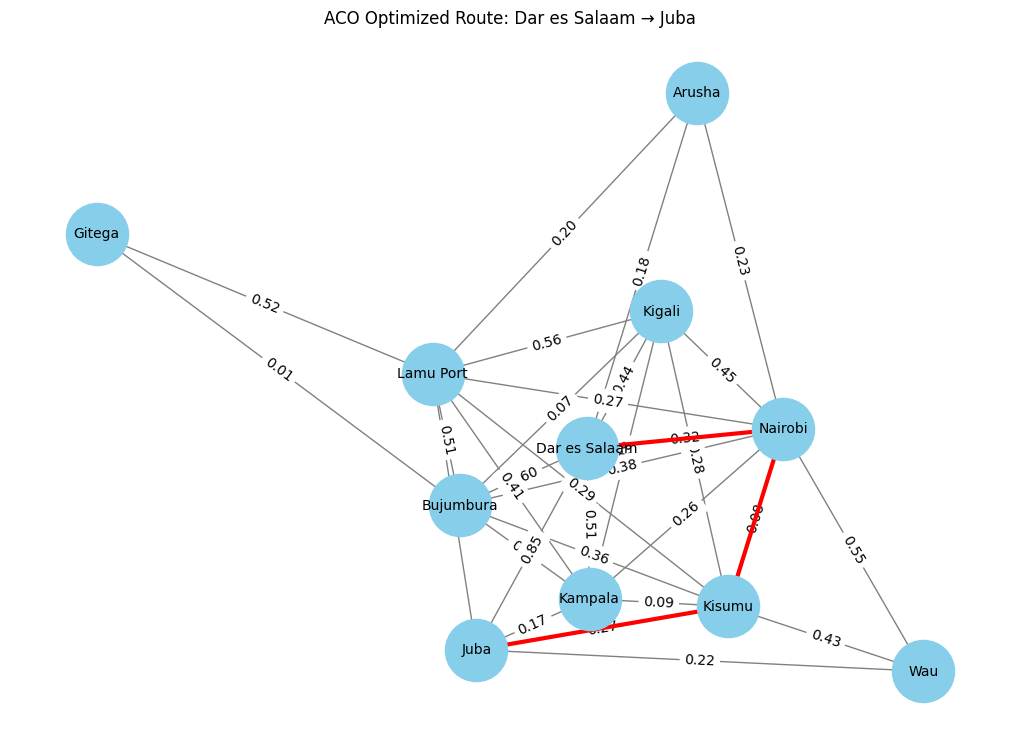

In [105]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import numpy as np
import pickle

# 1️⃣ Hyperparameters (You can later tune these)
NUM_ANTS = 15           # Suggest tuning between 5–50
NUM_ITERATIONS = 80     # Suggest tuning between 30–200
EVAPORATION_RATE = 0.4  # Suggest tuning 0.1–0.6
PHEROMONE_INIT = 1.0
ALPHA = 1.0             # Influence of pheromones
BETA = 2.0              # Influence of heuristic (edge weight)
Q = 1.0                 # Pheromone deposit factor

# 2️⃣ Create Graph G and extract edge weights (Assuming G already exists)
edge_weights = nx.get_edge_attributes(G, 'weight')

pheromones = {edge: PHEROMONE_INIT for edge in edge_weights}
heuristic = {edge: 1 / weight for edge, weight in edge_weights.items()}

# 3️⃣ Construct a path based on probabilities
def construct_solution(start, end):
    path = [start]
    current = start
    total_cost = 0

    while current != end:
        neighbors = [n for n in G.neighbors(current) if n not in path]
        if not neighbors:
            return path, float('inf')

        probabilities = []
        for neighbor in neighbors:
            edge = (current, neighbor) if (current, neighbor) in pheromones else (neighbor, current)
            tau = pheromones[edge] ** ALPHA
            eta = heuristic[edge] ** BETA
            probabilities.append(tau * eta)

        probabilities = np.array(probabilities)
        probabilities /= probabilities.sum()
        next_city = np.random.choice(neighbors, p=probabilities)

        edge = (current, next_city) if (current, next_city) in edge_weights else (next_city, current)
        total_cost += edge_weights.get(edge, float('inf'))
        path.append(next_city)
        current = next_city

    return path, total_cost

# 4️⃣ Pheromone update rule
def update_pheromones(paths, costs):
    for edge in pheromones:
        pheromones[edge] *= (1 - EVAPORATION_RATE)
    for path, cost in zip(paths, costs):
        for i in range(len(path) - 1):
            edge = (path[i], path[i+1]) if (path[i], path[i+1]) in pheromones else (path[i+1], path[i])
            pheromones[edge] += Q / cost

# 5️⃣ Total distance from path using df
def calculate_total_distance_from_path(df, path):
    distance = 0
    for i in range(len(path) - 1):
        segment = df[(df["City of Origin"] == path[i]) & (df["Destination City"] == path[i+1])]
        if not segment.empty:
            distance += segment["Distance (km)"].iloc[0]
        else:
            reverse_segment = df[(df["City of Origin"] == path[i+1]) & (df["Destination City"] == path[i])]
            if not reverse_segment.empty:
                distance += reverse_segment["Distance (km)"].iloc[0]
    return distance

# 6️⃣ ACO Driver
def ant_colony_optimization(start, end):
    best_path = None
    best_distance = float('inf')

    for _ in range(NUM_ITERATIONS):
        paths, costs = [], []

        for _ in range(NUM_ANTS):
            path, _ = construct_solution(start, end)
            if not path: continue
            total_km = calculate_total_distance_from_path(df, path)
            paths.append(path)
            costs.append(total_km)

            if total_km < best_distance:
                best_path = path
                best_distance = total_km

        update_pheromones(paths, costs)

    return best_path, best_distance  # both in kilometers


# 7️⃣ Get user input
start = input("Enter starting city: ").strip()
destination = input("Enter destination city: ").strip()
try:
    load_weight = float(input("Enter load weight (kg): ").strip())
except ValueError:
    print("Invalid load weight!")
    load_weight = 0

# 8️⃣ Run model
best_path, path_cost = ant_colony_optimization(start, destination)

if best_path:
    total_distance = calculate_total_distance_from_path(df, best_path)
    print(f"\n🚗 Best Route: {' → '.join(best_path)}")
    print(f"📏 Total Distance: {total_distance:.2f} km")
else:
    print("❌ No path found.")

# 9️⃣ Optional: Save model
with open('aco_model.pkl', 'wb') as f:
    pickle.dump((pheromones, heuristic, edge_weights, G), f)

# 🔟 Optional: Visualize Route
plt.figure(figsize=(10, 7))
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, node_size=2000, node_color="skyblue", edge_color="gray", font_size=10)
edge_labels = {(u, v): f"{d:.2f}" for u, v, d in G.edges(data="weight")}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

if best_path:
    path_edges = [(best_path[i], best_path[i+1]) for i in range(len(best_path) - 1)]
    nx.draw_networkx_edges(G, pos, edgelist=path_edges, edge_color="red", width=3)

plt.title(f"ACO Optimized Route: {start} → {destination}")
plt.show()


In [106]:
from sklearn.metrics import mean_squared_error

# Define known test city pairs (ensure they exist in the graph)
test_pairs = [
    ('Bujumbura', 'Nairobi'),
    ('Kigali', 'Juba'),
    ('Dar es Salaam', 'Kampala'),
    ('Nairobi', 'Juba'),
    ('Kampala', 'Butare')
]

# 1️⃣ Filter test pairs that exist in the graph
valid_test_pairs = [pair for pair in test_pairs if pair[0] in G.nodes and pair[1] in G.nodes]

# 2️⃣ Initialize lists for actual and predicted distances
actual_distances = []
predicted_distances = []

for start_city, end_city in valid_test_pairs:
    path, heuristic_cost = ant_colony_optimization(start_city, end_city)

    if path:
        # Use the path to compute real-world total distance from df
        total_km = calculate_total_distance_from_path(df, path)
        actual_distances.append(total_km)
        predicted_distances.append(heuristic_cost)  # ACO internal heuristic cost
    else:
        print(f"⚠️ Skipping pair: {start_city} → {end_city} (no path found)")

# 3️⃣ Compute MSE if valid predictions exist
if actual_distances and predicted_distances:
    mse = mean_squared_error(actual_distances, predicted_distances)
    print(f"\n📉 Mean Squared Error (MSE) between real distance and ACO heuristic: {mse:.4f}")
else:
    print("⚠️ Not enough valid test pairs to compute MSE.")



📉 Mean Squared Error (MSE) between real distance and ACO heuristic: 0.0000
